# TvsP_ABM

*An agent-based model to evaluate and compare the performance of an emission tax and permit market under heuristic behavior, heterogeneity, and dynamic markets.*

**Corresponding Publication**

Foramitti, J., Savin, I., & van den Bergh, J. (2021). Emission tax vs. permit trading under bounded rationality and dynamic markets. *Energy Policy*, 148, 112009. https://doi.org/10.1016/j.enpol.2020.112009

**Content**
1. Initialization
2. Settings & Parameters
3. Agents 
4. Markets
5. Main Dynamics
6. Model Analysis

### 1. Initialization

In [1]:
## Libraries ##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy
import csv

from operator import itemgetter
from tabulate import tabulate
from datetime import date

from SALib.sample import saltelli
from SALib.analyze import sobol

### 2. Settings & Parameters

In [2]:
# Simulation Settings

scenarios = ["No_Policy","Grandfathering","Grandfathering2","Auction","Tax"] # Which scenarios should be compared?

analyze_single_run = True # Show main dynamics for a single run
single_run_details = False # Show time-series for every variable
fixed_seed = True # Use fixed seed for random values? (makes results reproducible)
single_run_mode = "mid-point" # How to select from param_range: mid-point, upper-bound, lower-bound, random, id
glob_id = 1 # Id for single_run_mode

do_multi_run = False # Run over variation of paramters
analyze_multi_run = False # Calculate evaluation criteria
plot_multi_run = True # Plot evaluation criteria
analyze_sensitivity = False # Calculate indices
plot_sensitivity = True # Show sensitivity analysis plot
sensitivity_strength = 1 # For sobol sensitivity analysis

batch_seperation = False # Seperate multi-run into smaller batches
batch_total = 5 # Number of batches
batch_current = 0 # start counting from 0!
batch_combination = False # Combine batches

print_errors = False # Display error messages?

fs = 13 # Font size for plots

In [3]:
# Parameters

if fixed_seed == True: np.random.seed(42) 

param_range = {
    'num_vars': 17,
    'names': ['$N$','$γ$', '$ΔA_0$,$ΔB_0$', '$e^*$', '$m_0$', '$ϑ$', '$χ$', '$ω_1/ω_2$', '$δ$', '$Δδ$', '$α_{pot}$', '$α_{costs}$', '$Δα_{costs}$', '$η$', '$Δη$', '$ψ$', '$μ_1$,$μ_2$,$μ_3$'],
    'bounds': [[30   , 50  ], #00 - N - Number of firms
               [0.1  , 0.5 ], #01 - γ - Price sensitivity of demand
               [0    , 0.4 ], #02 - ΔA_0,ΔB_0 - Heterogeneity of production factors
               [0.1  , 0.2 ], #03 - e^* - Emission target
               [0.2  , 0.4 ], #04 - m0 - Initial mark-up
               [0.04 , 0.2 ], #05 - ϑ - Mark-up adaption rate 
               [0.025, 0.15], #06 - χ - Market-share adaption rate
               [0.2  , 5   ], #07 - ω_1/ω_2 - Market-share weight difference
               [0.05 , 0.3 ], #08 - δ - Permit price adaption rate 
               [0    , 0.4 ], #09 - Δδ - Heterogeneity of above
               [0.17 , 0.87], #10 - α_{pot} - Abatement potential
               [1    , 10  ], #11 - α_{costs} - Abatement cost factor 
               [0    , 0.4 ], #12 - Δα_{costs} - Heterogeneity of above
               [0    , 0.4 ], #13 - η - Investment profitability target
               [0    , 0.4 ], #14 - Δη - Heterogeneity of above
               [0    , 2   ], #15 - ψ - Auction mechanism 
               [0    , 3   ]] #16 - μ_1,μ_2,μ_3 - Expectation Rule
}

class c_parameters:
    def __init__(self,variable_parameters):

        # Fixed parameters
        #self.N = 30 # Number of firms
        self.TP = 30 # Number of periods
        self.t_start = 11 # Delay until policy starts
        self.t_period = 10 # Length of a regulation period
        self.t_impl = 10 # Number of implementation periods 
        self.D0 = 1 # Maximum demand
        self.A0 = 1 # Emission intensity
        self.B0 = 1 # Production costs
        self.λ_n = 20 # Number of technological steps
        self.pe0 = 0.01 # Initial permit price
        self.I_d = 0.1 # Desired inventory share
        
        # Expectation factor ranges
        exp_x_trend = [0.5,1]
        exp_x_adaptive = [0.25,0.75]
        
        # Calibration parameters
        self.calibration_treshold = 10**(-3)
        self.calibration_max_runs = 20 
        self.tax = 100 # Upper bound 
        
        # Variable parameters
        self.N, self.γ, self.ΔAB, self.E_max, self.m0, self.ϑ, self.χ, dω, self.δ, self.Δδ, self.λ_max, self.α, self.Δα, self.η, self.Δη, ex_mode, exp_mode = variable_parameters
        self.N = int(round(self.N))
        
        # Parameter preperation
        self.T = self.t_period * self.TP
        self.m0 = [self.m0] * self.N   
        self.ω = [dω/(dω+1),1/(dω+1)] 
        
        if ex_mode <= 1: self.ex_mode = "uniform"
        else: self.ex_mode = "discriminate"  
            
        if exp_mode < 1: 
            self.exp_mode = ["trend"] * self.N 
            self.exp_x = exp_x_trend[0] + (exp_x_trend[1]-exp_x_trend[0]) * (exp_mode-1)
        elif exp_mode < 2: 
            self.exp_mode = ["myopic"] * self.N 
            self.exp_x = 0
        else: 
            self.exp_mode = ["adaptive"] * self.N  
            self.exp_x = exp_x_adaptive[0] + (exp_x_adaptive[1]-exp_x_adaptive[0]) * (exp_mode-2) 
        
        # Toggle model dynamics
        self.calibrate = True 
        self.abatement = True  

        # Referencing shortcuts
        self.sec, self.reg, self.ex = [0]*3

        # Error log
        self.error = False
        self.log = []

    def generate_random_par(self):
        a = [self.δ * ( 1 + self.Δδ * ( np.random.random() - 0.5 ) )   for i in range(self.N)]
        b = [self.A0 * ( 1 + self.ΔAB * ( np.random.random() - 0.5 ) ) for i in range(self.N)]
        c = [self.B0 * ( 1 + self.ΔAB * ( np.random.random() - 0.5 ) ) for i in range(self.N)]
        d = [self.α * ( 1 + self.Δα * ( np.random.random() - 0.5 ) )   for i in range(self.N)]
        e = [self.η * ( 1 + self.Δη * ( np.random.random() - 0.5 ) )   for i in range(self.N)]
        return [a,b,c,d,e]
    
    def load_random_par(self,random_par):
        self.δ,self.A0,self.B0,self.α,self.η = random_par  
        
        self.λ = [] # Abatement List
        for i in range(self.N): self.λ.append( self.generate_λ(self.α[i],self.A0[i]) )
        
    # Abatement cost curve
    def generate_λ(self,α,A0):     
        λ =[] 
        for i in range(self.λ_n):
            a=(A0*self.λ_max)/self.λ_n
            MAC=a*α*(i+1) 
            b=a*MAC
            λ.append([a,b])
        return λ       
        
    # Manage errors
    def report_error(self,statement):
        self.error = True
        if statement not in self.log:
            self.log.append(statement)        

    # Scenarios 
    def load_sc(self,scenario):
        # Load Scenario
        getattr(self,scenario)() 
        
    def No_Policy(self):
        self.mode = "No Policy"
        self.emission_tax = False 
        self.permit_market = False   
        
    def Grandfathering(self):
        self.mode = "Grandfathering (E)"
        self.grandfathering_mode = 'emissions'
        self.emission_tax = False 
        self.permit_market = True  
        
    def Grandfathering2(self):
        self.mode = "Grandfathering (V)"
        self.grandfathering_mode = 'volume'
        self.emission_tax = False 
        self.permit_market = True  
        
    def Auction(self):
        self.mode = "Auction"
        self.emission_tax = False 
        self.permit_market = True       
        
    def Tax(self):
        self.mode = "Tax"
        self.emission_tax = True 
        self.permit_market = False  

### 3. Agents

In [4]:
# Regulator

class c_regulator:  
    
    def __init__(self,p):
        self.qp, self.pe, self.R = np.zeros((3,p.T+2)) 
        self.permit_market = False
        self.emission_tax = False
        self.x = 0 
   
    def update_policy(self,sec,p,t):  
        
        if t >= p.t_start: 
            self.x = min( (t - p.t_start)/p.t_period + 1 , p.t_impl ) # Step of gradual implementation  
            if p.emission_tax == True:
                self.emission_tax = True
                self.set_tax(sec,p,t)     
            if p.permit_market == True: 
                self.permit_market = True
                self.set_permits(sec,p,t)
                
    def set_permits(self,sec,p,t): 
   
        self.qp[t] = ( p.sec.E[p.t_start-1] - ( p.sec.E[p.t_start-1] - p.E_max ) * self.x / p.t_impl ) * p.t_period 
      
        for j in sec: j.u_i[t] = 0 # Expiration of old permits and trading account
            
        if p.mode == "Grandfathering (E)" or p.mode == "Grandfathering (V)":
            
            if p.grandfathering_mode == 'emissions':
            
                E_sum = sum([sec.E[ti-1] for ti in range(t-p.t_period,t)])

                if E_sum > 0: 
                    for j in sec:
                        j.u_i[t] = j.u_t[t] = self.qp[t] * sum([j.e[ti-1] for ti in range(t-p.t_period,t)]) / E_sum    
                else: 
                    j.u_i[t] = self.qp[t]/p.N
                    p.report_error("Error in set_permits(): E_sum = 0")
            
            if p.grandfathering_mode == 'volume':
            
                Q_sum = sum([sec.Q[ti-1] for ti in range(t-p.t_period,t)])

                if Q_sum > 0: 
                    for j in sec:
                        j.u_i[t] = j.u_t[t] = self.qp[t] * sum([j.qg[ti-1] for ti in range(t-p.t_period,t)]) / Q_sum    
                else: 
                    j.u_i[t] = self.qp[t]/p.N
                    p.report_error("Error in set_permits(): Q_sum = 0")

    def set_tax(self,sec,p,t): 
        
        self.pe[t:t+p.t_period] = p.tax * self.x / p.t_impl 
        for j in sec: j.pe[t:t+p.t_period] = j.c_e[t:t+p.t_period] = self.pe[t:t+p.t_period]
        
        
# Sector

class c_sector(list):
     
    def __init__(self,p):
        
        super().__init__()
        for j in range(p.N): self.append(c_firm(p,j,self))
            
        # Variable parameters  
        self.D, self.E, self.Q, self.u_t = np.zeros((4,p.T+2)) 
        
        # Initial values
        for j in self: j.s[0] = 1 / p.N      
        self.D[0] = p.D0 * np.exp(- sum([j.s[0] * j.pg[0] for j in self]) * p.γ) 
        for j in self: j.D[0] = j.qg_d[0] = j.qg[0] = j.qg_s[0] = j.s[0] * self.D[0] 
            
    def production(self,p,t):
        
        self.apply("production",p,t)
        
        # Document total emissions (for grandfathering)
        self.E[t] = sum([j.e[t] for j in self])
        
        # Document quantity share (for abatement decomposition)
        self.Q[t] = sum([j.qg[t] for j in self])
        for j in self:
            if self.Q[t] > 0: j.sq[t] = j.qg[t]/self.Q[t]
            else: j.sq[t] = 1/p.N
        
    def apply(self, method,p,t):
        # Run method in each list element
        for obj in self:
            getattr(obj, method)(p,t)         


# Firm         
              
class c_firm:
    
    def __init__(self,p,j,sec):
        
        # Parameters
        self.j = j # Firm Index Number
        self.sec = sec # Firm sector
        self.α = p.α[j] # Abatement cost factor
        self.δ = p.δ[j] # Permit price adaption rate
        self.η = p.η[j] # Profitability target for investments
        self.exp_mode = p.exp_mode[j] # Expectation rule
        self.λ = copy.deepcopy(p.λ[j]) # List of abatement options [[a,b],[a,b],...]
        self.λ0 = copy.deepcopy(p.λ[j]) # Copy of list for documentation
        self.x = p.exp_x # Expectation factor
        
        # Dynamic variables
        self.s, self.sq, self.f, self.e, self.qg, self.qg_s, self.qg_d, self.qg_I, self.D, self.Dl, self.pg, self.m, self.A, self.B, self.pe, self.pe2, self.qp_d, self.u_i, self.u_t, self.cu_t, self.c_e, self.c_pr = np.zeros((22,p.T+2)) 
        
        # Initial values
        self.m[0] = p.m0[j] # Mark-up rate
        self.pg[0] = p.B0[j] * ( 1 + p.m0[j] ) # Sales price
        self.A[0] = self.A[1] = p.A0[j] # Emission intensity
        self.B[0] = self.B[1] = p.B0[j] # Production costs
        if p.permit_market == True: self.pe[p.t_start] = p.pe0 # Permit price
        
    def set_expectations(self,p,t):

        # Set desired output
        if self.exp_mode == "trend" and t <= 1: self.qg_d[t] = self.D[t-1] + self.x * ( self.D[t-1] - self.D[t-2] )
        elif self.exp_mode == "adaptive": self.qg_d[t] = self.x * self.D[t-1] + ( 1 - self.x ) * self.qg_d[t-1]
        else: self.qg_d[t] = self.D[t-1]
            
        self.qg_d[t] = max( 0, self.qg_d[t] * ( 1 + p.I_d ) - self.qg_I[t-1] ) 
        
        # Set desired mark-up            
        if t != 1 and self.s[t-2] > 0.01: self.m[t] = self.m[t-1] * ( 1 +  p.ϑ * ( self.s[t-1] - self.s[t-2] ) / self.s[t-2] ) 
        else: self.m[t] = self.m[t-1] 

    def order_permits(self,p,t):
        
        self.qp_d[t] = qp_d = self.qg_d[t] * self.A[t] * tl(p,t) - self.u_i[t]
        if qp_d != 0:
            order=[self.pe[t], qp_d ,self]
            p.ex.orders.append(order) 
                    
    def production(self,p,t):
        
        # Production
        if p.reg.permit_market == True: 
            if self.A[t] * tl(p,t) > 0:
                self.qg[t] = min( self.qg_d[t] , self.u_i[t] / ( self.A[t] * tl(p,t) ) )
            else: p.report_error("Error in production(): self.A[t] * tl(p,t) <= 0")
        else: self.qg[t] = self.qg_d[t]
        
        # Emissions  
        self.e[t] = self.qg[t] * self.A[t] 
        
        # Inventory update
        self.qg_I[t] = self.qg_I[t-1] + self.qg[t]
        
        # Sales price
        self.pg[t] = max( 0 , ( self.A[t] * self.pe[t] + self.B[t] ) * ( 1 + self.m[t] ) ) 
        
        # Tax collection and permit submission
        if p.reg.emission_tax == True: p.reg.R[t] += self.e[t] * self.pe[t]
        if p.reg.permit_market == True: self.u_i[t] = self.u_i[t+1] = self.u_i[t] - self.e[t] 

    def abatement(self,p,t):
        
        o,a,b = [0] * 3
        
        if len(self.λ) > 0: # Check if there are abatement options left
            
            a,b = self.λ[0] # Extract best abatement option
            MAC = b / a # Marginal costs of abatement
            
            if p.abatement == True and MAC * ( 1 + self.η ) <= self.pe[t] and self.s[t-1] > 0.01: 
                
                o = 1 # Activate abatement
                self.λ.pop(0) # Remove used option from list
        
        # Update production factors
        self.A[t+1] = self.A[t] - o * a
        self.B[t+1] = self.B[t] + o * b


### 4. Markets

In [5]:
# Trading Exchange 
            
class c_exchange:
    
    def __init__(self,p):
        self.orders = [] # Market orders [Price, Quantity, Firm]
        self.pe, self.u_t, self.t_r = np.zeros((3,p.T+2)) # Market price, traded volume, trading rounds

    def auction(self,sec,p,t):
        
        np.random.shuffle(self.orders) # Shuffle list for same-price orders
        self.orders.sort(key=itemgetter(0)) # Sort list by price (lowest first) 
        bids = [x for x in self.orders if x[1] >= 0] 
        bids.reverse() # Highest first
        Q = p.reg.qp[t] # Cap
        sbids = []
        
        # Select successful bids
        while len(bids) > 0 and Q > bids[0][1]:     
            Q -= bids[0][1]
            sbids.append(bids[0])
            self.pe[t] = bids[0][0]
            bids.pop(0)
        
        for b in sbids:
            b[2].pe[t] *= ( 1 - b[2].δ ) # Learning 1: Successfull orders
        
        # Last bid (does not count as successfull)
        if len(bids) > 0 and Q <= bids[0][1]:
            self.pe[t] = bids[0][0]
            sbids.append([bids[0][0],Q,bids[0][2]])
            Q -= bids[0][1]
        
        # Process successful bids
        for b in sbids: 
            if p.ex_mode == "uniform": pr = self.pe[t] 
            elif p.ex_mode == "discriminate": pr = b[0]
            b[2].u_i[t] += b[1] # Inventory
            p.reg.R[t] += b[1] * pr # Revenue
            b[2].u_t[t] += b[1] # Trade log
            b[2].cu_t[t] += b[1] * pr # Trade log
            
        # Learning 2: Unsuccessfull orders
        for b in bids: b[2].pe[t] *= ( 1 + b[2].δ )
            
        # Grandfathering, if there are permits left 
        if Q > 0:
                
            E_sum = sum([sec.E[ti-1] for ti in range(t-p.t_period,t)])
            
            if E_sum > 0: 
                for j in sec:
                    j.u_i[t] = j.u_t[t] = j.u_i[t] + Q * sum([j.e[ti-1] for ti in range(t-p.t_period,t)]) / E_sum    
            else: 
                j.u_i[t] = j.u_i[t] + Q/p.N
                p.report_error("Error in auction(): E_sum = 0")
                
        self.orders = [] # Reset orders
    
    def clear(self,sec,p,t):
        
        np.random.shuffle(self.orders) # Shuffle list for same-price orders
        self.orders.sort(key=itemgetter(0)) # Sort list by price (lowest first)
        
        # Seperate asks (lowest first) and bids (highest first)
        asks = [x for x in self.orders if x[1] < 0]
        bids = [x for x in self.orders if x[1] >= 0] 
        bids.reverse() 
        
        self.t_r[t] += 1 # Document new trading round
        if len(bids) == 0 or len(asks) == 0: self.active = False
        else: self.active = True
        
        sbids =[]
        sasks =[]
        
        for i in sec:
            i.u_td = 0 # Trading volume of current trading iteration
            
        # As long as there is a higher bid than ask
        while len(bids) > 0 and len (asks) > 0 and bids[0][0] > asks[0][0]: 

            b = bids[0] 
            a = asks[0] 

            if b[1] > - a[1]: # If demand bigger than supply
                q = - a[1] # Trade volume
                b[1] -= q # Substraced from demand
                sasks.append(asks[0])
                asks.pop(0)  
            elif b[1] < - a[1]: 
                q = b[1]
                a[1] += q
                sbids.append(bids[0])
                bids.pop(0)               
            else: # Volumes are equal
                q = b[1]
                sasks.append(asks[0])
                sbids.append(bids[0])
                bids.pop(0)
                asks.pop(0)

            # Inventory update            
            b[2].u_i[t] += q 
            a[2].u_i[t] -= q

            # Trading log
            self.pe[t] = a[0] # Market-price
            pt_m = ( b[0] + a[0] ) /2
            
            self.u_t[t] += q  
            b[2].u_t[t] += q
            a[2].u_t[t] -= q 
            
            a[2].u_td += q 
            b[2].u_td -= q 
            
            if p.ex_mode == "discriminate":       
                b[2].cu_t[t] += q * pt_m
                a[2].cu_t[t] -= q * pt_m

        # Market price if there is no trade
        if self.u_t[t] == 0 and len (asks) > 0: self.pe[t] = asks[0][0] # Only sellers
        elif len(bids) > 0 and len (asks) == 0: self.pe[t] = bids[0][0] # Only buyers
            
        if p.ex_mode == "uniform":
            for b in sbids: b[2].cu_t[t] += b[2].u_td * self.pe[t] 
            for a in sasks: a[2].cu_t[t] += a[2].u_td * self.pe[t] 

        # Learning
        for b in sbids: b[2].pe[t] *= ( 1 - b[2].δ )             
        for a in sasks: a[2].pe[t] *= ( 1 + a[2].δ )  
        for b in bids: b[2].pe[t] *= ( 1 + b[2].δ ) 
        for a in asks: a[2].pe[t] *= ( 1 - a[2].δ ) 
        
        self.orders = [] # Reset orders
        
        
    def end_of_permit_trade(self,sec,p,t):
        
        p.reg.pe[t] = self.pe[t] # Report to regulator
        
        for j in sec:  
            
            # Average permit costs
            u=sum([j.u_t[ti]  for ti in range(t-tp(p,t),t+1)])
            if u>0: j.c_e[t] = sum([ j.cu_t[ti] for ti in range(t-tp(p,t),t+1)]) / u
            
            # Keep permit trading price
            j.pe[t] = j.pe[t+1] = max(0,j.pe[t]) 
            
            
# Commodity Market

def trade_commodities(sec,p,t):
    
    for j in sec: j.f[t] = - p.ω[0] * j.pg[t] - p.ω[1] * j.Dl[t-1] # Fitness
    f_mean = sum([j.f[t] * j.s[t-1] for j in sec]) # Average fitness
    for j in sec: j.s[t] = max( 0 , j.s[t-1] * (1 -  p.χ * (j.f[t] - f_mean) / f_mean) ) # Market-share evolution
    p_mean = sum([j.s[t] * j.pg[t] for j in sec]) # Average price
    sec.D[t] = D = p.D0 * np.exp(- p_mean * p.γ) # Total demand 
        
    for j in sec:
        j.D[t] = j.s[t] * D # Demand allocation    
        j.qg_s[t] = min(j.D[t],j.qg_I[t]) # Sold goods
        j.qg_I[t] -= j.qg_s[t] # Inventory update
        j.Dl[t] = j.D[t] - j.qg_s[t] # Unfilled demand
                
    # Correct for numerical errors
    x = 1 - sum([j.s[t] for j in sec])
    if x != 0:
        for i in sec: i.s[t] = i.s[t] * 1 / (1-x)
                 
            
# Other functions

def tl(p,t): # Rounds that are left until the end of the period
    return p.t_period - (t-1)%p.t_period

def tp(p,t): # Rounds that have already passed within this period
    return (t-1)%p.t_period

### 5. Main Dynamics

In [6]:
## Main Dynamics ##

# Single Run

def run_model(scenarios,param_values=0,calibrating=False,p_cal=0):
    
    results = []

    # Set up random parameters
    if calibrating == False:
        pr = c_parameters(param_values)
        random_par = pr.generate_random_par()
    
    # Iterate through all scenarios
    for scenario in scenarios: 

        # Load parameters
        if calibrating == False: 
            p = c_parameters(param_values)
            p.load_sc(scenario)
            p.load_random_par(random_par)
        else: p = p_cal 
            
        # Calibrate tax    
        if scenario == "Tax" and p.calibrate == True and calibrating == False: calibrate_tax(p)
        
        # Initialize agents
        p.sec = sec = c_sector(p) # Sector & firms
        p.reg = reg = c_regulator(p) # Regulator
        p.ex = ex = c_exchange(p) # Trading exchange
        
        # Run simulation
        t = 1

        while t <= p.T:

            if (t-1)%p.t_period == 0: reg.update_policy(sec,p,t)

            sec.apply("set_expectations",p,t)
           
            if reg.permit_market == True:
                
                ex.active = True
                while ex.active == True:

                    sec.apply("order_permits",p,t)
                    if p.mode == "Auction" and (t-1)%p.t_period == 0: 
                        p.ex.auction(sec,p,t)   
                        ex.active = False
                    else: ex.clear(sec,p,t)

                    if ex.t_r[t] > 50:
                        p.report_error("Error in trading exchange loop: more than 50 trading rounds")
                        ex.active = False

                ex.end_of_permit_trade(sec,p,t)
                
            sec.apply("abatement",p,t)    
            sec.production(p,t)
            trade_commodities(sec,p,t)   

            t += 1 # Move to next round
        
        results.append([sec,p])
        
        # Check for Errors
        if print_errors == True and p.error == True and calibrating == False: 
            print("Errors found in Scenario ",scenario)
            print(p.log)
        
    return results

# Calibrate Tax so that it reaches target

def calibrate_tax(p_cal):
    c=0
    mintax = 0
    maxtax = p_cal.tax
    
    p_cal.tax = (mintax + maxtax) / 2

    results = run_model(["Tax"],p_cal=p_cal,calibrating=True)
    sec,p = results[0]

    while abs(sec.E[p.T-1] - p.E_max) > p.calibration_treshold:
        
        if sec.E[p.T-1] >= p.E_max: mintax = p_cal.tax
        else: maxtax = p_cal.tax
        p_cal.tax = (mintax + maxtax) / 2
        
        results = run_model(["Tax"],p_cal=p_cal,calibrating=True)
        sec,p = results[0]
        c+=1
        
        if c>p.calibration_max_runs:
            p_cal.report_error("Error in calibrate_tax: c_max reached")
            break       
    
    return 


# Prepare Evaluation Measures - Decomposition of abatement

def calc_abatement_analysis(sc):

    sec,p = sc
    
    t0 = 1 # Start here
    T = p.T+1 # End here

    ΔE = [sum([j.e[t]-j.e[t0] for j in sec]) for t in range(t0,T)]
    ab_tot = [-x for x in ΔE]

    ΔQ = [sum([j.qg[t]-j.qg[t0] for j in sec]) for t in range(t0,T)]

    # Decomposition into production and technology

    def x1(sec,j,t): # Technology change
        return (j.qg[t0] + j.qg[t]) / 2 * ( j.A[t] - j.A[t0] )

    def x2(sec,j,t): # Production change
        return (j.A[t0] + j.A[t]) / 2 * ( j.sq[t] * sec.Q[t] - j.sq[t0] * sec.Q[t0]) 

    ab_1 = [- sum([ x1(sec,j,t) for j in sec]) for t in range(t0,T)] 
    ab_2 = [- sum([ x2(sec,j,t) for j in sec]) for t in range(t0,T)] 

    # Further decomposition of production level

    def x21(sec,j,t): # Compositional change
        return (sec.Q[t0] + sec.Q[t]) / 2 * (j.sq[t] - j.sq[t0]) 

    def x22(sec,j,t): # Overall production level change
        return (j.sq[t0] + j.sq[t]) / 2 * (sec.Q[t] - sec.Q[t0]) 

    def A_mean(sec,j,t):
        return (j.A[t0] + j.A[t]) / 2    

    ab_21 = [ - sum([ x21(sec,j,t) * A_mean(sec,j,t) for j in sec]) for t in range(t0,T)] # Compositional change
    ab_22 = [ - sum([ x22(sec,j,t) * A_mean(sec,j,t) for j in sec]) for t in range(t0,T)] # Overall production level change
    
    return [ab_21, ab_1,ab_22,ab_tot]


# Prepare Evaluation Measures - Calculate Measures

measure_names = ['Run','Scenario','Emissions','Abatement \n Costs','Emission \n Costs','Technology \n Adoption','Compositional \n Change','Product \n Sales','Profit \n rate','Market \n Concentration','Sales \n Price','Consumer \n Impact','Emission \n Price','Trading \n Volume']
                 
def evaluation_measures(results,i):
    
    measures = []
    
    for sc in results:
        
        sec0,p0 = results[0]
        sec,p = sc
        t=p.T+1
        
        # Effectiveness & Economic Impact
        E =   sum([ sec.E[ti]                                    for ti in range(t-p.t_period,t)  ]) 
        CA = sum([ sum([(j.B[ti]-j.B[1])*j.qg[ti] for j in sec]) for ti in range(t-p.t_period,t)  ]) / E 
        CE =  sum([ sum([j.e[ti]*j.c_e[ti] for j in sec])        for ti in range(t-p.t_period,t)  ])
        HHI = sum([ sum([j.s[ti]**2   for j in sec])             for ti in range(t-p.t_period,t)  ])
        
        # Efficiency / Abatement Decomposition
        ac,at,ar,ab_tot = calc_abatement_analysis(sc) #"Compositional change","Technology adoption","Reduction of total production"
        AT =  sum(at[t-p.t_period:t])
        AC =  sum(ac[t-p.t_period:t])
        
        # Consumer Impact
        S =   sum([ sum([j.qg_s[ti]   for j in sec]) for ti in range(t-p.t_period,t)  ])
        PL =  sum([ sum([ j.qg_s[ti] * ( j.pg[ti] - ( j.c_e[ti] * j.A[ti] + j.B[ti] ) )  for j in sec]) for ti in range(t-p.t_period,t)]) / sum([ sum([ j.qg[ti] * ( j.c_e[ti] * j.A[ti] + j.B[ti] ) for j in sec]) for ti in range(t-p.t_period,t)])   
        CC0 = sum([ sum([j.s[ti] * j.pg[ti]  for j in sec]) for ti in range(t-p.t_period,t)  ]) / 10
        CC =  sum([ sum([j.s[ti] * j.pg[ti]  for j in sec]) for ti in range(t-p.t_period,t)  ]) / 10 - sum([ p.reg.R[ti] for ti in range(t-p.t_period,t)  ]) / S
        R =   sum([ p.reg.R[ti] for ti in range(t-p.t_period,t)  ])
        
        # Others
        PE =  sum([ p.reg.pe[ti] for ti in range(t-p.t_period,t)  ])
        TV =  sum([ p.ex.u_t[ti] for ti in range(t)  ])

        measures.append([i,p.mode,E,CA,CE,AT,AC,S,PL,HHI,CC0,CC,PE,TV]) # Corresponds with measure_names
    
    return measures


# Perform Multiple Runs

def multi_run(scenarios,param_range):
    
    # Prepare sample
    param_values_multi = saltelli.sample(param_range, sensitivity_strength, calc_second_order=False) 
    
    if batch_seperation:
        batch_len = int ( len(param_values_multi) / batch_total )
        param_values_multi = param_values_multi[batch_len*batch_current:batch_len*(batch_current+1)]
    
    measures = []
    n_err = 0
    n_err_s = 0
    err = False
    
    for i,pv in enumerate(param_values_multi): 
        
        if i == 0:
            print("Single run-time:")
            results = %time run_model(scenarios,param_values=pv)
            print("\nScheduled runs: ",len(param_values_multi))
        else: 
            results = run_model(scenarios,param_values=pv)
        
        # Check for errors and try to repeat
        err = False
        for sc in results:
            if sc[1].error == True: 
                err = True
                      
        if err == True: 
            n_err +=1  
            c=0
            while True:
                results = run_model(scenarios,param_values=pv)

                err = False
                for sc in results:
                    if sc[1].error == True: 
                        err = True

                if err == False:
                    n_err_s +=1
                    break
                else: 
                    c+=1
                    if c>10: break
                
        measures.extend( evaluation_measures(results,i) )
        
        print('\rDone: ' + str(i+1) + ' (' + str(n_err) + ' Errors, ' + str(n_err_s) + ' resolved)', end='')
      
    print("\n\nTotal run-time:")
    
    return measures

### 6. Model Analysis

#### 7.2 Single Run

In [7]:
## Scenario Run ## 111
if analyze_single_run == True:
    
    print("Starting Single Run")
    
    param = []
    for par in param_range['bounds']:
        if single_run_mode == "mid-point": param.append((par[0]+par[1])/2)
        if single_run_mode == "upper-bound": param.append(par[1])
        if single_run_mode == "lower-bound": param.append(par[0])
        if single_run_mode == "random": param.append(par[0]+(par[1]-par[0])*np.random.random())
        if single_run_mode == "id": param=saltelli.sample(param_range, sensitivity_strength)[glob_id]
    
    # param[1] = 0.5 
    
    %time results = run_model(scenarios,param)
    
    # Technological Optimism
    param2 = copy.deepcopy(param)
    param2[10]=0.87
    param2[11]=1
    results2 = run_model(scenarios,param2)
    
    # Discriminate Auction
    param3 = copy.deepcopy(param)
    param3[12]=2
    results3 = run_model(scenarios,param3)    
    
    
    # Both of the above
    param4 = copy.deepcopy(param)
    param4[10]=0.87
    param4[11]=1
    param4[12]=2
    results4 = run_model(scenarios,param4)    
    

Starting Single Run
Wall time: 7.65 s


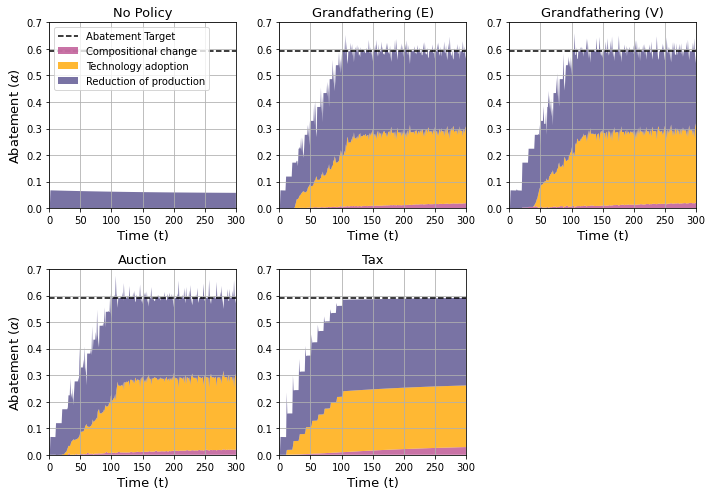

In [8]:
# Abatement Decomposition 
            
def plot_abatement_analysis(results):

    sec,p=results[0]
    t0=1
    T = p.T # End here
    
    fig=plt.figure(figsize=(10,7))
    columns = 3
    rows = 2
    
    #fig, ([[ax0,ax1,ax4],[ax2, ax3,ax5]]) = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
    #axs = [ax0,ax1,ax2,ax3,ax4]

    axs=[0]
    
    i=1
    for sc in results:
        if True:
            
            ax = fig.add_subplot(rows, columns, i)
            axs.append(ax)
            
            sec,p=sc
            axs[i].set_title(p.mode, fontsize = fs)
            
            ab_21, ab_1,ab_22,ab_tot = calc_abatement_analysis(sc)
        
            pal = ["#bc5090","#ffa600", "#58508d", "#003f5c"] 
            stacks = axs[i].stackplot(range(t0,p.T+1), ab_21, ab_1,ab_22,  labels=["Compositional change","Technology adoption","Reduction of production"], alpha=0.8, colors=pal)
            axs[i].axhline(p.sec.E[t0]-p.E_max,color='black',ls='--',label='Abatement Target') # Abatement Target Line
            #axs[i].plot(range(t0,p.T),ab_tot,label="Total Abatement")
            axs[i].set_xlabel('Time (t)', fontsize = fs)
            axs[i].grid()
            axs[i].set_xlim([0,300])
            axs[i].set_ylim([0,0.7])
            
        i+=1

    axs[1].set_ylabel("Abatement ($α$)", fontsize = fs) 
    axs[4].set_ylabel("Abatement ($α$)", fontsize = fs) 
    axs[1].legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Outputs/abatement.pdf')

if analyze_single_run == True:
    plot_abatement_analysis(results)   

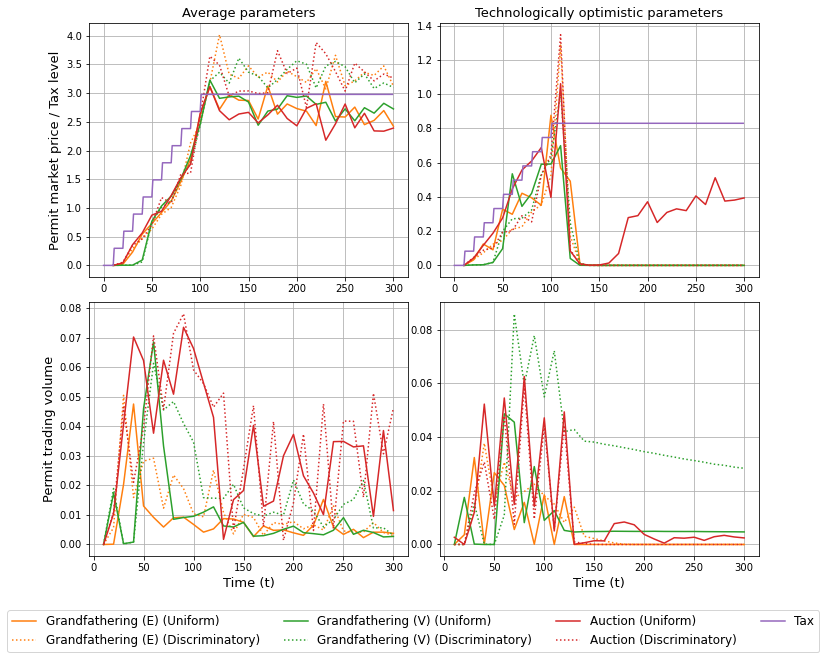

In [9]:
# Permit Trading Dynamics

def plot_permit_market_dynamics(results): 
    
    fig, ([ax1, ax3],[ax2, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
        
    sec,p = results[1]
    x=range(10,p.T+10,10)
    l1, = ax1.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (E) (Uniform)', color='C1')  
    
    sec,p = results3[1]
    l2, = ax1.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (E) (Discriminatory)', color='C1', linestyle=':') 
    
    sec,p = results[2]
    x=range(10,p.T+10,10)
    l1, = ax1.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (V) (Uniform)', color='C2')  
    
    sec,p = results3[2]
    l2, = ax1.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (V) (Discriminatory)', color='C2', linestyle=':') 
    
    sec,p = results[3]
    l3, = ax1.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Auction (Uniform)', color='C3')         
    
    sec,p = results3[3]
    l4, = ax1.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Auction (Discriminatory)', color='C3', linestyle=':')      
        
    sec,p = results[4]
    l5, = ax1.plot(range(p.T),[p.reg.pe[t] for t in range(p.T)], label='Tax', color='C4')    
            
    # Technological Optimistic Setting

    sec,p = results2[1]
    ax3.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (E) (TO)', color='C1') 
    
    sec,p = results4[1]
    ax3.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (E) (TO Discriminatory)', color='C1', linestyle=':') 
    
    sec,p = results2[2]
    ax3.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (V) (TO)', color='C2') 
    
    sec,p = results4[2]
    ax3.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (V) (TO Discriminatory)', color='C2', linestyle=':') 
    
    sec,p = results2[3]
    ax3.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Auction (TO)', color='C3')   
    
    sec,p = results4[3]
    ax3.plot(x,  [sum([p.reg.pe[ti] for ti in range(t-10,t)])/10 for t in x], label='Auction (TO Discriminatory)', color='C3', linestyle=':')    

    sec,p = results2[4]
    ax3.plot(range(p.T),[p.reg.pe[t] for t in range(p.T)], label='Tax (TO)', color='C4')
    
    ax1.set_ylabel('Permit market price / Tax level', fontsize = fs)

    
    
    sec,p = results[1]
    ax2.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (E)', color='C1')  
    
    sec,p = results3[1]
    ax2.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (E) (Discriminatory)', color='C1', linestyle=':')  
    
    sec,p = results[2]
    ax2.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (V)', color='C2')  
    
    sec,p = results3[2]
    ax2.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (V) (Discriminatory)', color='C2', linestyle=':')  
    
    sec,p = results[3]
    ax2.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in x], label='Auction', color='C3')  
    
    sec,p = results3[3]
    ax2.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in x], label='Auction (Discriminatory)', color='C3', linestyle=':')  
    
    
    
    sec,p = results2[1]
    ax4.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (TO)', color='C1') 
    
    sec,p = results4[1]
    ax4.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in range(0,p.T,10)], label='Grandfathering (TO Discriminatory)', linestyle=':', color='C1') 

    sec,p = results2[2]
    ax4.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in x], label='Grandfathering (TO)', color='C2') 
    
    sec,p = results4[2]
    ax4.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in range(0,p.T,10)], label='Grandfathering (TO Discriminatory)', linestyle=':', color='C2') 
    
    sec,p = results2[3]
    ax4.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in range(0,p.T,10)], label='Auction (TO)', color='C3')   
    
    sec,p = results4[3]
    ax4.plot(x,[sum([p.ex.u_t[ti] for ti in range(t-10,t)])/10 for t in range(0,p.T,10)], label='Auction (TO Discriminatory)', linestyle=':', color='C3')   
    
              
        
    ax2.set_xlabel('Time (t)', fontsize = fs)
    ax4.set_xlabel('Time (t)', fontsize = fs)
    ax2.set_ylabel('Permit trading volume', fontsize = fs)
    
    ax1.set_title("Average parameters", fontsize = fs)
    ax3.set_title("Technologically optimistic parameters", fontsize = fs)
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    
    fig.subplots_adjust(bottom=0.14, hspace=0.1,wspace=0.1)
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=fs-1) 
    plt.savefig('Outputs/permits.pdf')
    
if analyze_single_run == True:
    plot_permit_market_dynamics(results)

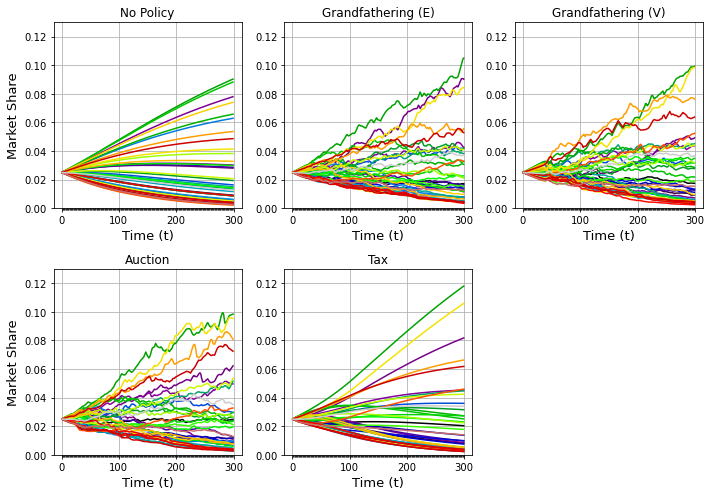

In [10]:
# Market Shares

def plot_market_share(ax,sec,p):
    
    x = np.linspace(0, 1, 10)
    number = p.N
    cmap = plt.get_cmap('nipy_spectral')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    
    end = p.T
    ts = range(1,end)
    for i, color in enumerate(colors):
        ax.plot(ts,[sec[i].s[t] for t in ts], label=f'Producer {sec[i].j}, α = {sec[i].α}', color=color)
    ax.set_xlabel('Time (t)', fontsize = fs)
    ax.set_xticks(np.arange(1,end, 1),minor = True)
    ax.grid()

def plot_market_shares(results):
    
    #fig, ([[ax0,ax1], [ax2, ax3]]) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    #axs = [ax0,ax1,ax2,ax3]
    
    fig=plt.figure(figsize=(10,7))
    columns = 3
    rows = 2
    
    i=1
    axs=[0]
    
    for sc in results:
        if True: #i>0:
            sec,p = sc
            
            ax=fig.add_subplot(rows, columns, i)
            axs.append(ax)
            
            plot_market_share(axs[i],sec,p)
            axs[i].set_ylim((0,0.13))
            axs[i].set_title(p.mode)
        i+=1
    #ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].set_ylabel("Market Share", fontsize = fs)
    axs[4].set_ylabel("Market Share", fontsize = fs)  
    
    plt.tight_layout()
    plt.savefig('Outputs/market-shares.pdf')

if analyze_single_run == True:
    plot_market_shares(results)

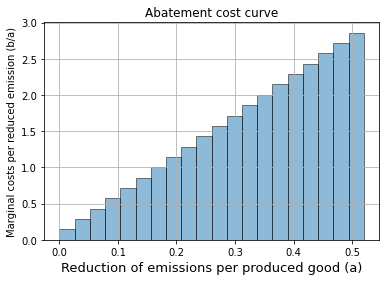

In [11]:
# Abatement Cost Curve - Example

def generate_λ(A0,α,p):     
    λ =[] 
    for i in range(p.λ_n):
        a=(A0*p.λ_max)/p.λ_n #* (i+1) 
        MAC=a*α*(i+1) 
        b=a*MAC
        λ.append([a,b])
    return λ      

if analyze_single_run == True:
    sec,p=results[0]
    ab0 = generate_λ(1,5.5,p)

    arr = np.array([ [a[1]/a[0] for a in ab0] , [a[0] for a in ab0] ])
    plt.title("Abatement cost curve")
    data = arr[:,arr[0,:].argsort()]

    cumsum = np.cumsum([0]+list(data[1]))
    pos = cumsum[:-1]

    plt.bar(pos, data[0], data[1], align='edge', linewidth=1,edgecolor='black', alpha=0.5)

    plt.xlabel('Reduction of emissions per produced good (a)', fontsize=fs)
    plt.ylabel('Marginal costs per reduced emission (b/a)')
    plt.grid()
    plt.savefig('Outputs/mac2.pdf')
    plt.show()
    

In [12]:
## Detailled Analysis ##

def fplot(variable,label,mode,ax,sec):
    
    start = 1
    end = p.T
    ts = range(start,end) 

    if mode == "ind":
        for i in range(p.N):
            exec("ax.plot(ts,[sec["+str(i)+"]."+variable+"[t] for t in ts], label=f'Producer {sec["+str(i)+"].j}')") 
    if mode == "sum":
        exec("ax.plot(ts,[sum([j."+variable+"[t] for j in sec1]) for t in ts],'k-')")
    ax.set_xlabel('time (t)')
    ax.set_ylabel(label)
    ax.set_xticks(np.arange(start,end, 1),minor = True)
    ax.grid()

def plot_main_dynamics(sec,p):

    fig, ((ax1, ax2,ax3), (ax4,ax5,ax6), (ax7, ax8,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

    fplot("qg","Production (qg)","ind",ax1,sec)
    fplot("m","mark-up (m)","ind",ax2,sec)
    fplot("c_e","Emission cost (c_e)","ind",ax3,sec)
    fplot("pe","Emission price (pe)","ind",ax4,sec)
    fplot("A","Emission Intensity (A)","ind",ax5,sec)
    fplot("B","Production costs (B)","ind",ax6,sec)
    fplot("pg","Sales Price","ind",ax7,sec)
    fplot("e","Emissions","ind",ax8,sec)
    fplot("s","Market-share (s)","ind",ax9,sec)

    plt.tight_layout()

if single_run_details == True:
    for i in range(0,len(scenarios)): 
        sec, p = results3[i]
        print("Scenario ",i)
        print(p.mode)
        plot_main_dynamics(sec,p)
        plt.show()

In [13]:
## Plot Tables of Variables over Time ##

def plot_tables(sec,p,start,end):

    for j in range(2): # len(sec)
        f = sec[j]
        m = [["c_e"]+list(f.c_e),["Dl"]+list(f.Dl),["pe"]+list(f.pe),["e"]+list(f.e),["s"]+list(f.s),["f"]+list(f.f),["A"]+list(f.A),["B"]+list(f.B),["D"]+list(f.D),["qg_s"]+list(f.qg_s),["qg_d"]+list(f.qg_d),["qg_I"]+list(f.qg_I),["qg"]+list(f.qg),["qp_d"]+list(f.qp_d),["m"]+list(f.m),["pg"]+list(f.pg),["pe"]+list(f.pe),["u_i"]+list(f.u_i)]
        m2 = [[i[0]]+i[start+1:end] for i in m]
        headers =  ["FIRM "+str(j)]+list(range(start,end))
        table = tabulate(m2, headers, floatfmt=".3f")
        print(table)
        print("\n")    

if single_run_details == True:
    sec,p = results3[1] # Choose Scenario
    start,end = [290,303] # Choose table time-span
    plot_tables(sec,p,start,end)

#### 6.1 Multiple Runs

In [14]:
# Main Simulation over Parameter Range 222
if do_multi_run == True and batch_combination == False:
    measures = %time multi_run(scenarios,param_range)

In [15]:
# Create Panda Dataframe
if do_multi_run == True and batch_combination == False:    
    df = pd.DataFrame( measures , columns = measure_names )
    
    if batch_seperation: df.to_csv(f'Outputs/results_TVSP_batch_{str(batch_current)}.csv',index=False)
    else: df.to_csv(r'Outputs/results_TVSP.csv',index=False)

In [16]:
if batch_combination == True: 
    
    df_p1 = pd.read_csv('Outputs/results_TVSP_batch_0.csv')
    df_p2 = pd.read_csv('Outputs/results_TVSP_batch_1.csv')
    df_p3 = pd.read_csv('Outputs/results_TVSP_batch_2.csv')
    df_p4 = pd.read_csv('Outputs/results_TVSP_batch_3.csv')
    df_p5 = pd.read_csv('Outputs/results_TVSP_batch_4.csv')

    l = df_p1.shape[0]
    ll = int(l/5)   # number of scenarios 
    
    df_p2.index += l
    df_p3.index += l * 2
    df_p4.index += l * 3
    df_p5.index += l * 4

    df_p2['Run'] += ll
    df_p3['Run'] += ll * 2
    df_p4['Run'] += ll * 3
    df_p5['Run'] += ll * 4

    df = pd.concat([df_p1,df_p2,df_p3,df_p4,df_p5])
    
    df.to_csv('Outputs/results_TVSP_batch_combined.csv',index=False)

In [17]:
# Calculate relative values

def relative_measures(df):
    
    dfsc = df0['Scenario']
    df = df0.drop(['Scenario'], axis=1) # Remove scenario column
    
    st = str( len( df.index.unique() ) )
    
    for i in df.index.unique():
        df.loc[i] = df.loc[i].div( df.loc[i].abs().sum() ,axis=1)
        print('\rDone: ' + str(i+1) + ' out of ' + st, end='')
        
    df['Scenario'] = dfsc # Add scenario column back in
    
    return df

if analyze_multi_run == True:
    df0 = pd.read_csv('Outputs/results_TVSP_batch_combined.csv')
    df0 = df0.set_index('Run')
    
    df = relative_measures(df0)
    df.to_csv(r'Outputs/measures_relative_for_multi.csv',index=False)

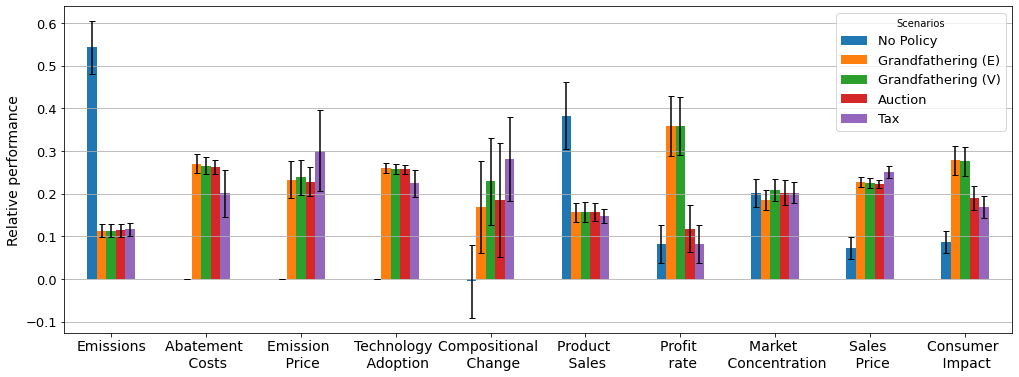

In [18]:
# Plot bar chart

def multi_run_bar_chart(df,mode="single"):
    
    # Calculate relative values
    df0 = df.set_index('Scenario')
    x = 10 # out of 9
    xx = [0,1,10,3,4,5,6,7,8,9]
    measure_names_p = list( measure_names[i+2] for i in xx )
    
    # Run Statistics
    df1 = df0.iloc[:,xx]
    gp1 = df1.groupby(level=('Scenario'),sort=False)
    means = gp1.mean().T
    errors = gp1.std().T

    # Plot Aggregate Values
    means.plot.bar(yerr=errors, capsize=3, figsize=(17, 6)) #
    
    plt.grid(axis='y', zorder=0)
    #plt.ylim(bottom=0, top=1)
    plt.legend(title="Scenarios",fontsize=fs)
    plt.ylabel('Relative performance', fontsize = fs+1)
    #plt.xlabel('Evaulation measures $m$', fontsize = fs)
    plt.xticks(np.arange(x), measure_names_p, rotation=0, fontsize=fs+1)
    plt.yticks(fontsize=fs)
    plt.savefig('Outputs/multi_run_bar_chart2.pdf')
    plt.show() 
    
if plot_multi_run == True:
    df = pd.read_csv('Outputs/measures_relative_for_multi.csv')
    multi_run_bar_chart(df) 

In [19]:
# Sensitivity Analysis
# More information at: https://salib.readthedocs.io/en/latest/api.html

if analyze_sensitivity == True:
    
    # Calculate relative values only for Auction & Tax
    dfs = pd.read_csv('Outputs/results_TVSP_batch_combined.csv')   
    dfs = dfs.iloc[:,[0,1,2, 3, 12, 5, 6, 7, 8, 9, 10, 11]] #Select only certain measures
    dfs = dfs.set_index('Run')
    dfs = dfs.loc[dfs['Scenario'].isin(['Tax','Auction']) ]

    dfsc = dfs['Scenario']
    dfs = dfs.drop(['Scenario'], axis=1) # Remove scenario column

    st = str( len( dfs.index.unique() ) )

    for i in dfs.index.unique():
        dfs.loc[i] = dfs.loc[i].div( dfs.loc[i].abs().sum() ,axis=1)
        print('\rDone: ' + str(i+1) + ' out of ' + st, end='')

    dfs['Scenario'] = dfsc # Add scenario column back in
    dfs.to_csv(r'Outputs/results_taxauction.csv',index=False)
    print("\n Relative measures calculated")

In [20]:
if analyze_sensitivity == True: 
    
    dfs = pd.read_csv('Outputs/results_taxauction.csv')   
    dfauc = dfs.loc[dfs['Scenario'].isin(['Auction'])].drop(['Scenario'], axis=1)
    dftax = dfs.loc[dfs['Scenario'].isin(['Tax'])].drop(['Scenario'], axis=1)
    dfdif = dftax.reset_index() - dfauc.reset_index()
    dfdif = dfdif.drop(['index'], axis=1)
    dfdif.to_csv(r'Outputs/results_diftaxauction2.csv',index=False)

In [21]:
if analyze_sensitivity == True:
    
    print("Dataset prepared")

    Y = []
    measure_names_s = []

    for i in dfdif.columns:
        measure_names_s.append(i)
        Y.append( list(dfdif[i]) )

    Y = np.array(Y)

    np.save('Outputs/taxvspermit_measures2.npy', measure_names_s)

    # Calculate Sobol Indices
    Si = []
    i=1
    for y in Y: 
        Si.append( sobol.analyze(param_range, y, calc_second_order=False) )
        print("Finished calculating measure ",i)
        i+=1

    np.save('Outputs/measure_names2', measure_names_s)
    np.save('Outputs/sensitivity_analysis2.npy', Si) 
    print("Done")

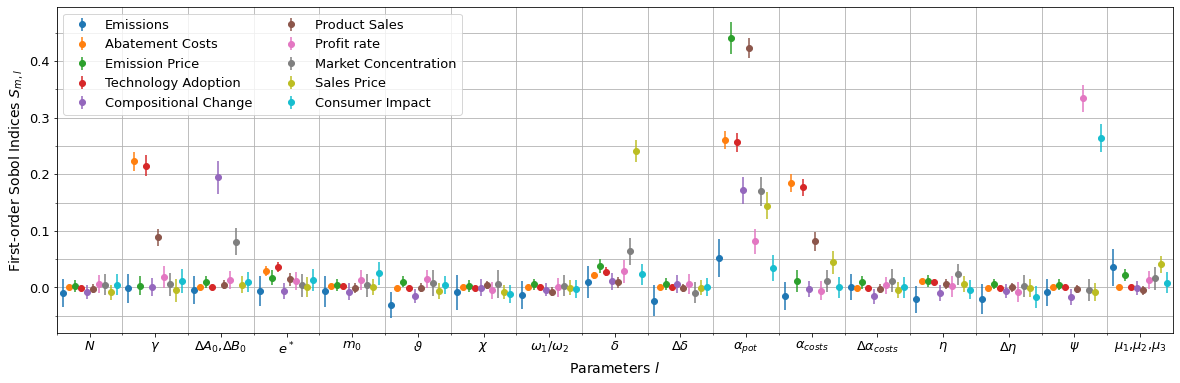

In [22]:
# Plot Sensitivity Analysis - Single Order

if plot_sensitivity == True:
    
    Si = np.load('Outputs/sensitivity_analysis2.npy', allow_pickle = True)
    
    measure_names_s = ['Emissions', 'Abatement \n Costs', 'Emission \n Price',
       'Technology \n Adoption', 'Compositional \n Change',
       'Product \n Sales', 'Profit \n rate', 'Market \n Concentration',
       'Sales \n Price','Consumer \n Impact'] 
    
    for i in range(len(measure_names_s)): measure_names_s[i] = measure_names_s[i].replace('\n ', '')
    
    fig, ax = plt.subplots(figsize=(20, 6)) 

    n = 10
    
    for i in range(n):
        y = Si[i]
        c=1/(n+1)
        x = [c+j+c*i for j in list(range(len(y['S1'])))] 
        ax.errorbar(x, y['S1'], yerr=y['S1_conf'],  linestyle='', marker='o', label= measure_names_s[i])#
    
    x = list(range(len(y['S1'])))
    y = list(np.arange(-0.05,0.5, 0.05))
    ax.set_yticks(y, minor = True)
    ax.set_xticks(x, minor = True)
    ax.set_xticks([x+0.5 for x in x], minor = False)
    ax.set_xticklabels(param_range['names'], fontsize = fs)
    ax.set_xlim(0, 17)
    #ax.set_ylim(-0.05, 0.5)

    plt.ylabel('First-order Sobol Indices $S_{m,l}$', fontsize = fs+1)
    plt.xlabel('Parameters $l$', fontsize = fs+1)
    plt.yticks(fontsize=fs)
    ax.grid(which='major',axis='y')
    ax.grid(which='minor',axis='y')
    ax.grid(which='minor',axis='x')
    ax.legend(loc='upper left',ncol=2, fontsize = fs)
    plt.savefig('Outputs/sensitivity_chart.pdf')
    plt.show()

In [23]:
# Sensitivity Plot - Total Order

if analyze_sensitivity == True and False:
    
    Si = np.load('Outputs/sensitivity_analysis2.npy', allow_pickle = True)
    measure_names_s = np.load('Outputs/measure_names2.npy')
    
    for i in range(len(measure_names_s)): measure_names_s[i] = measure_names_s[i].replace('\r\n ', '')

    fig, ax = plt.subplots(figsize=(15, 6)) 

    n = 7    
    for i in range(n):
        y = Si[i]
        c=1/(n+1)
        x = [c+j+c*i for j in list(range(len(y['S1'])))] 
        ax.errorbar(x, y['ST'],yerr=y['ST_conf'],  linestyle='', marker='o', label=measure_names_s[i]) 
    
    x = list(range(len(y['S1'])))
    y = list(np.arange(0.1,1.2, 0.05))
    ax.set_yticks(y, minor = True)
    ax.set_xticks(x, minor = True)
    ax.set_xticks([x+0.5 for x in x], minor = False)
    ax.set_xticklabels(param_range['names'], fontsize = fs)
    ax.set_xlim(0, 17)
    
    ax.set_ylabel('Total-order Sobol Indices $S_{T_{m,l}}$', fontsize = fs+1)
    ax.set_xlabel('Parameters $l$', fontsize = fs+1)
    ax.grid(which='minor')
    plt.yticks(fontsize=fs)
    ax.legend(loc='upper left',ncol=2, fontsize = fs)
    plt.savefig('Outputs/sensitivity_chart_total.pdf')
    plt.show()


In [24]:
# Table of Evaluation Measures 555

if analyze_sensitivity == True:

    dfdif2 = pd.read_csv('Outputs/results_diftaxauction2.csv')   
    df8 = dfdif2.copy() * 100

    # Overall results

    means1 = df8.mean().T
    errors1 = df8.std().T
    variance1 = df8.var().T

    # Auctioning Mode

    x = np.array( [i[15] for i in saltelli.sample(param_range, sensitivity_strength, calc_second_order=False) ] ) # Add array of parameter 15 (ex_mode)

    df82 = df8.copy()
    df82.insert(2, "ex_mode", x, True) 
    select_disc = df82["ex_mode"] > 1 # Discriminate
    df8disc = df82[select_disc].drop("ex_mode", axis=1)

    means2 = df8disc.mean().T
    variance2 = df8disc.var().T

    df83 = df8.copy()
    df83.insert(2, "ex_mode", x, True) 
    select_uni = df83["ex_mode"] <= 1 # Uniform
    df8uni = df83[select_uni].drop("ex_mode", axis=1)

    means3 = df8uni.mean().T
    variance3 = df8uni.var().T

    # Technological Optimism

    x = np.array( [i[10] for i in saltelli.sample(param_range, sensitivity_strength, calc_second_order=False) ] ) # Add array of parameter 10 (alpha_pot)

    df84 = df8.copy()
    df84.insert(2, "alpha_pot", x, True) 
    select = df84["alpha_pot"] <= 0.52
    df8uni = df84[select].drop("alpha_pot", axis=1)

    means4 = df8uni.mean().T
    variance4 = df8uni.var().T

    df84 = df8.copy()
    df84.insert(2, "alpha_pot", x, True) 
    select = df84["alpha_pot"] > 0.52
    df8uni = df84[select].drop("alpha_pot", axis=1)

    means5 = df8uni.mean().T
    variance5 = df8uni.var().T

    # Heterogeneity (ΔA,ΔB)

    x = np.array( [i[2] for i in saltelli.sample(param_range, sensitivity_strength, calc_second_order=False) ] ) # Add array of parameter 2 DELTA AB

    df84 = df8.copy()
    df84.insert(2, "alpha_pot", x, True) 
    select = df84["alpha_pot"] <= 0.2
    df8uni = df84[select].drop("alpha_pot", axis=1)

    means6 = df8uni.mean().T
    variance6 = df8uni.var().T

    df84 = df8.copy()
    df84.insert(2, "alpha_pot", x, True) 
    select = df84["alpha_pot"] > 0.2
    df8uni = df84[select].drop("alpha_pot", axis=1)

    means7 = df8uni.mean().T
    variance7 = df8uni.var().T
    
    
    # Demand Sensitivity γ
    
    x = np.array( [i[1] for i in saltelli.sample(param_range, sensitivity_strength, calc_second_order=False) ] ) # Add array of parameter 2 DELTA AB

    df84 = df8.copy()
    df84.insert(2, "gamma", x, True) 
    select = df84["gamma"] <= 0.3
    df8uni = df84[select].drop("gamma", axis=1)

    means8 = df8uni.mean().T
    variance8 = df8uni.var().T

    df84 = df8.copy()
    df84.insert(2, "gamma", x, True) 
    select = df84["gamma"] > 0.3
    df8uni = df84[select].drop("gamma", axis=1)

    means9 = df8uni.mean().T
    variance9 = df8uni.var().T
    
    
    # Permit price adaption rate delta
    
    x = np.array( [i[8] for i in saltelli.sample(param_range, sensitivity_strength, calc_second_order=False) ] ) # Add array of parameter 2 DELTA AB

    df84 = df8.copy()
    df84.insert(2, "gamma", x, True) 
    select = df84["gamma"] <= 0.175
    df8uni = df84[select].drop("gamma", axis=1)

    means10 = df8uni.mean().T
    variance10 = df8uni.var().T

    df84 = df8.copy()
    df84.insert(2, "gamma", x, True) 
    select = df84["gamma"] > 0.175
    df8uni = df84[select].drop("gamma", axis=1)

    means11 = df8uni.mean().T
    variance11 = df8uni.var().T
    

    # Prepare Strings for Table ( in LaTeX format )

    d1 = "& \makecell[lc]{" + means1.round(2).astype(str) + "\\\\(" + variance1.round(2).astype(str) + ") }"
    d2 = "& \makecell[lc]{" + means2.round(2).astype(str) + "\\\\(" + variance2.round(2).astype(str) + ") }"
    d3 = "& \makecell[lc]{" + means3.round(2).astype(str) + "\\\\(" + variance3.round(2).astype(str) + ") }"
    d4 = "& \makecell[lc]{" + means4.round(2).astype(str) + "\\\\(" + variance4.round(2).astype(str) + ") }"
    d5 = "& \makecell[lc]{" + means5.round(2).astype(str) + "\\\\(" + variance5.round(2).astype(str) + ") }"
    d6 = "& \makecell[lc]{" + means6.round(2).astype(str) + "\\\\(" + variance6.round(2).astype(str) + ") }"
    d7 = "& \makecell[lc]{" + means7.round(2).astype(str) + "\\\\(" + variance7.round(2).astype(str) + ") }" 
    d8 = "& \makecell[lc]{" + means8.round(2).astype(str) + "\\\\(" + variance8.round(2).astype(str) + ") }" 
    d9 = "& \makecell[lc]{" + means9.round(2).astype(str) + "\\\\(" + variance9.round(2).astype(str) + ") }" 
    d10 = "& \makecell[lc]{" + means10.round(2).astype(str) + "\\\\(" + variance10.round(2).astype(str) + ") }" 
    d11 = "& \makecell[lc]{" + means11.round(2).astype(str) + "\\\\(" + variance11.round(2).astype(str) + ") } \\\\[3ex] " 
    
    df = pd.concat([d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11], axis=1)
    header = pd.Series(["Overall","Discriminate","Uniform","Techn. optimistic","Techn. pessimistic","Heterogeneity low","Heterogeneity high","gamma low","gamma high","delta low","delta high"])
    df = df.rename(columns = header)
    df.index = ['Emissions', 'Abatement Costs', 'Emission Price',
       'Technology Adoption', 'Compositional Change',
       'Product Sales', 'Profit rate', 'Market Concentration',
       'Sales Price','Consumer Impact'] 
    
    #df.to_csv(r'Outputs/results_table.csv',index=False)